Bibliotecas necesarias para la práctica

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D

Código para poder acceder a los directorios de la cuenta de drive de un usuario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Directorio que contiene las imágenes
DATA_DIR = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Código necesario para cargar las imágenes y las máscaras

In [ ]:
#Ruta de las imágenes
PATH_TEST_images = DATA_DIR+"data_segmentation/test/images/"
PATH_TEST_mask = DATA_DIR+"data_segmentation/test/mask/"
PATH_TRAIN_images = DATA_DIR+"data_segmentation/train/images/"
PATH_TRAIN_mask = DATA_DIR+"data_segmentation/train/mask/"

imagenes_train = []
mascaras_train = [] 
imagenes_test = []
mascaras_test = [] 
#PAra el train
counter = 0
for filename in os.listdir(PATH_TRAIN_images):
    filename = PATH_TRAIN_images+filename
    #Como hay imágenes de distintos tamaños, la llevamos todas al mismo tamaño
    img = cv2.resize(cv2.imread(filename),(256, 256)) 
    imagenes_train.append(img)
    counter += 1
    print("Leidas " + str(counter) + " imágenes de -> train")

counter = 0
for filename in os.listdir(PATH_TRAIN_mask):
    filename = PATH_TRAIN_mask+filename
    #las mascaras las leeremos en escala de grises
    img = cv2.resize(cv2.imread(filename, 0),(256, 256))
    #umbralizamos con 0 y 1 porque solo nos interesa conocer si hay peatones o no
    #el número de peatones y la identificación de los mismos es irrelevante
    img[img!=0] = 1 
    mascaras_train.append(img)
    counter += 1
    print("Leidas " + str(counter) + " mascaras de -> train")
#Realizamos lo mismo para el conjunto test
counter = 0
for filename in os.listdir(PATH_TEST_images):
    filename = PATH_TEST_images+filename
    img = cv2.resize(cv2.imread(filename),(256, 256)) 
    imagenes_test.append(img)
    counter += 1
    print("Leidas " + str(counter) + " imágenes de -> test")

counter = 0
for filename in os.listdir(PATH_TEST_mask):
    filename = PATH_TEST_mask+filename
    img = cv2.resize(cv2.imread(filename, 0),(256, 256)) 
    img[img!=0] = 1 
    mascaras_test.append(img)
    counter += 1
    print("Leidas " + str(counter) + " mascaras de -> test")

mascaras_test = np.array(mascaras_test)
mascaras_train = np.array(mascaras_train)
imagenes_train = np.array(imagenes_train)
imagenes_test = np.array(imagenes_test)

Leidas 1 imágenes de -> train
Leidas 2 imágenes de -> train
Leidas 3 imágenes de -> train
Leidas 4 imágenes de -> train
Leidas 5 imágenes de -> train
Leidas 6 imágenes de -> train
Leidas 7 imágenes de -> train
Leidas 8 imágenes de -> train
Leidas 9 imágenes de -> train
Leidas 10 imágenes de -> train
Leidas 11 imágenes de -> train
Leidas 12 imágenes de -> train
Leidas 13 imágenes de -> train
Leidas 14 imágenes de -> train
Leidas 15 imágenes de -> train
Leidas 16 imágenes de -> train
Leidas 17 imágenes de -> train
Leidas 18 imágenes de -> train
Leidas 19 imágenes de -> train
Leidas 20 imágenes de -> train
Leidas 21 imágenes de -> train
Leidas 22 imágenes de -> train
Leidas 23 imágenes de -> train
Leidas 24 imágenes de -> train
Leidas 25 imágenes de -> train
Leidas 26 imágenes de -> train
Leidas 27 imágenes de -> train
Leidas 28 imágenes de -> train
Leidas 29 imágenes de -> train
Leidas 30 imágenes de -> train
Leidas 31 imágenes de -> train
Leidas 32 imágenes de -> train
Leidas 33 imágene

In [ ]:
#Convertimos las mascaras en dos canales, uno solo contiene la información del fondo
#y otra de los peatones, 0 y 1
mascaras_train = tf.keras.utils.to_categorical(mascaras_train, num_classes=2, dtype='float32')   
np.shape(mascaras_train)
mascaras_test = tf.keras.utils.to_categorical(mascaras_test, num_classes=2, dtype='float32')   
np.shape(mascaras_test)

(74, 256, 256, 2)

In [ ]:
print(np.shape(imagenes_train))
print(np.shape(mascaras_train))
print(np.shape(imagenes_test))
print(np.shape(mascaras_test))

(96, 256, 256, 3)
(96, 256, 256, 2)
(74, 256, 256, 3)
(74, 256, 256, 2)


Modelo de red autocodificadora

In [ ]:
#la primera capa indicamos la dimensión de las imágenes de entrada
inputs = tf.keras.layers.Input((256,256,3))
#convolucionamos con una capa de convolución con 64 filtros y núcleos de 3*3, la función activadora es la relu
down_conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same",  activation='relu')(inputs)
#aplicamos maxpooling
down_conv_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same")(down_conv_1)
#repetimos el proceso, cada vez obtenemos matrices de menor dimensión, codificando los datos relevantes
down_conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same",  activation='relu')(down_conv_1)
down_conv_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same")(down_conv_2)
    
down_conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same",  activation='relu')(down_conv_2)
    
down_conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(down_conv_3)
#la siguiente parte es la decodificadora que nos lleva los datos a un espacio latente con las características obtenidas con las 
#capas de convolución, para ello usaremos Conv2DTraspose hasta obtener una dimension del espacio latente igual al de las máscaras 
up_conv_1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding="same")(down_conv_4)
    
up_conv_2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding="same")(up_conv_1)
#En la última capa usaremos una función de activación softmax para realizar la clasificación  
outputs = tf.keras.layers.Conv2D(filters=2, kernel_size=(1,1), strides=(1,1), padding="same", activation="softmax")(up_conv_2)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

compilamos la red

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss="categorical_crossentropy",
              #añadimos la métrica meaniou para ver como de distintas son las máscaras 
              #generadas en el espacio latente y la de los datos dados
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

Entrenamos la red

In [ ]:
history = model.fit(imagenes_train, mascaras_train, epochs=5, validation_data=(imagenes_test, mascaras_test))

Epoch 1/5
3/3 [==============================] - 39s 13s/step - loss: 5.5235 - accuracy: 0.5191 - mean_io_u: 0.3596 - val_loss: 2.9573 - val_accuracy: 0.8165 - val_mean_io_u: 0.6899
Epoch 2/5
3/3 [==============================] - 39s 13s/step - loss: 3.8451 - accuracy: 0.7614 - mean_io_u: 0.6148 - val_loss: 2.9573 - val_accuracy: 0.8165 - val_mean_io_u: 0.6899
Epoch 3/5
3/3 [==============================] - 39s 13s/step - loss: 3.8451 - accuracy: 0.7614 - mean_io_u: 0.6148 - val_loss: 2.9573 - val_accuracy: 0.8165 - val_mean_io_u: 0.6899
Epoch 4/5
3/3 [==============================] - 39s 13s/step - loss: 3.8451 - accuracy: 0.7614 - mean_io_u: 0.6148 - val_loss: 2.9573 - val_accuracy: 0.8165 - val_mean_io_u: 0.6899
Epoch 5/5
3/3 [==============================] - 39s 13s/step - loss: 3.8451 - accuracy: 0.7614 - mean_io_u: 0.6148 - val_loss: 2.9573 - val_accuracy: 0.8165 - val_mean_io_u: 0.6899


Calculamos las predicciones y visualizamos la máscara y el espacio latente de la predicción

In [ ]:
predicciones = model.predict(imagenes_test)

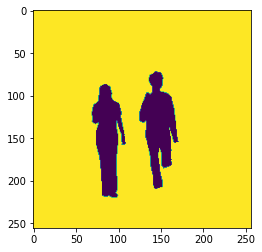

In [ ]:
plt.imshow(mascaras_test[0,:,:,0])

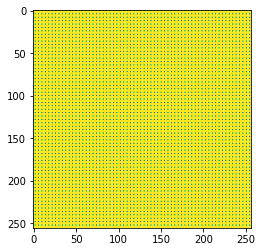

In [ ]:
plt.imshow(predicciones[1,:,:,0])